In [9]:
import torch

import torchvision
from torchvision import datasets,transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tqdm import tqdm

import sys, os
sys.path.append('..')

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

## データセット

In [6]:
# https://qiita.com/coticoticotty/items/5fe4a7f3c740523eb2fb

In [3]:
# https://tkstock.site/2022/05/29/python-pytorch-mydataset-dataloader/

data = []

DATADIR = "../data/hiragana73"
#CATEGORIES = ["U3042", "U3044", "U3046", "U3048", "U304A"]

for CATEGORIES in os.listdir(DATADIR):
    if CATEGORIES != ".DS_Store":
        for img_path in os.listdir(DATADIR + "/" + CATEGORIES)[:100]:
            #data.append([(DATADIR + "/" + CATEGORIES + "/" + img_path), img_path, CATEGORIES, CATEGORIES])
            data.append((DATADIR + "/" + CATEGORIES + "/" + img_path))
        # print(DATADIR + "/" + CATEGORIES)
        # break

df = pd.DataFrame(data, columns=['path'])
df.head()

,path
0,../data/hiragana73/U3081/1942_1877910_0247.png
1,../data/hiragana73/U3081/1941_1133168_0068.png
2,../data/hiragana73/U3081/1935_1264256_0398.png
3,../data/hiragana73/U3081/1929_1453088_0040.png
4,../data/hiragana73/U3081/1900_754949_0023.png


In [5]:
class HiraganaDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df
        image_paths = df["path"].to_list()
        # self.input_size = input_size
        self.len = len(image_paths)
        # self.transform = transform
        # self.phase = phase
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):  
        image_path = self.df["path"].to_list()[index]
        # 画像の読込
        #image = cv2.imread(image_path)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # 2値化
        image = np.array(image)
        image = ~image
        _, image = cv2.threshold(image, 0, 1, cv2.THRESH_OTSU)
        image = image.astype(np.float32) # Dataloader で使うために転置する?

        img_size, _ = image.shape
        ax = np.array(range(0, img_size))
        X, Y = np.meshgrid(ax, ax)
        data = np.stack([X, Y, image]).astype(np.float32)
        
        # label はここでは自分自身
        label = image
        return data, label

In [6]:
def make_hiragana_dataset(DATADIR, ratio=0.7):
    data = []

    for CATEGORIES in os.listdir(DATADIR):
        if CATEGORIES != ".DS_Store":
            for img_path in os.listdir(DATADIR + "/" + CATEGORIES)[:100]:
                data.append((DATADIR + "/" + CATEGORIES + "/" + img_path))

    df = pd.DataFrame(data, columns=['path'])

    hiragana_dataset = HiraganaDataset(df)

    train_dataset, valid_dataset = torch.utils.data.random_split(hiragana_dataset, [int(len(hiragana_dataset)*ratio), int(len(hiragana_dataset)*(1-ratio))])

    return train_dataset, valid_dataset

In [7]:
DATADIR = "../data/hiragana73"

train_dataset, valid_dataset = make_hiragana_dataset(DATADIR)

In [8]:
# バッチサイズの指定

batch_size = 10

# DataLoaderを作成

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# 辞書にまとめる

dataloaders_dict = {
    'train': train_dataloader, 
    'valid': valid_dataloader
}

# 動作確認
# イテレータに変換
batch_iterator = iter(dataloaders_dict['train'])

# 1番目の要素を取り出す

inputs, labels = next(batch_iterator)

print(inputs.size())

print(labels.size())

print(inputs.dtype)

torch.Size([10, 3, 48, 48])
torch.Size([10, 48, 48])
torch.float32


## 回転

In [10]:
transform = transforms.Compose(
    [transforms.RandomRotation(degrees=[-180, 180]),]
)

In [18]:
rotated = transform(inputs)

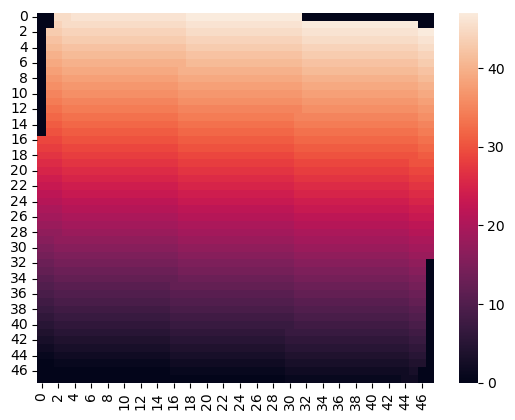

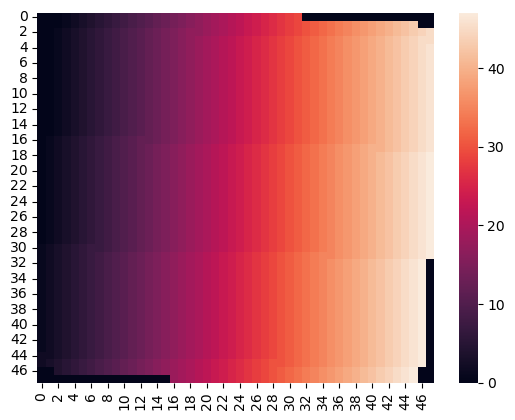

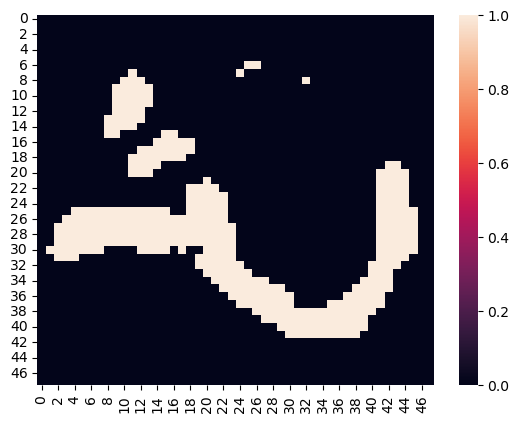

In [21]:
#rotated = transform(inputs)
for i in range(3):
    sns.heatmap(rotated.detach().numpy()[0, i])
    plt.show()

## 訓練

In [ ]:
def train_loop(gen, disc, opt, train_dataloader, device):
    gen.train()
    epoch_loss = 0
    transform = transforms.Compose(
        [transforms.RandomRotation(degrees=[-180, 180]),]
    )
    for src_batch, tgt_batch in tqdm(train_dataloader):
        src_batch.to(device)
        tgt_batch.to(device)

        src_batch = transform(src_batch) #データ拡張追加
        # 生成
        points = gen(src_batch)
        # 評価
        loss = disc(points, tgt_batch)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()
        
    return epoch_loss / len(train_dataloader)

def valid_loop(gen, disc, opt, val_dataloader, device):
    gen.eval()
    total_loss = 0
    with torch.no_grad():
        for src_batch, tgt_batch in tqdm(val_dataloader):
            src_batch.to(device)
            tgt_batch.to(device)
            # 生成
            points = gen(src_batch)
            # 評価
            loss = disc(points, tgt_batch)
            total_loss += loss.detach().item()
        
    return total_loss / len(val_dataloader)

def train(gen, disc, DATADIR, batch_size=100, num_epochs=30, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'using: {device}')

    train_dataset, valid_dataset = make_hiragana_dataset(DATADIR)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

    gen = gen.to(device)
    disc = disc.to(device)

    opt=optim.Adadelta(gen.parameters(), lr=lr)

    train_loss_list = []
    validation_loss_list = []
    #min_validation_loss = 

    for epoch in range(num_epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)
        print("Training")
        train_loss = train_loop(gen, disc, opt, train_dataloader, device)
        train_loss_list += [train_loss]
        print("Validating")
        validation_loss = valid_loop(gen, disc, opt, val_dataloader, device)
        validation_loss_list += [validation_loss]
        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        # if validation_loss < min_validation_loss:
        #     min_validation_loss = validation_loss
        #     model_list = glob.glob("../model/*")
        #     for prev_model in model_list:
        #         os.remove(prev_model)
        #     torch.save(model.state_dict(), "../model/best.pt")
    
    # errors = disc.error_log
    # distances = disc.distance_log
    # distributions = disc.distribution_log
    
    # return train_loss_list, validation_loss_list, errors, distances, distributions
    return train_loss_list, validation_loss_list

## モデル

In [97]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

In [98]:
class PlotLine2(nn.Module):
    # 太さも操作可能にする
    # input: [N, points_num, 3]
    def __init__(self, img_size):
        super().__init__()
        self.img_size = img_size

        self.cmp_num = int(img_size*np.sqrt(2))
        self.co = torch.tensor(range(0, img_size)).to(torch.float).unsqueeze(0) # 座標ベクトル
        t = torch.tensor(range(0, self.cmp_num+1))/self.cmp_num
        self.ts = torch.stack((1-t, t)).to(torch.float) # 補完ベクトル
    
    def forward(self, points):
        N = points.size()[0] # batch_size
        
        point_pairs = torch.cat((torch.zeros([N,1,3]),
                                 points.repeat([1,1,2]).reshape([N,-1,3]),
                                 torch.zeros([N,1,3])),dim=1).reshape([N, -1, 2, 3])[:, 1:-1]
        
        segs_points = torch.matmul(self.ts.mT, point_pairs)
        
        line_points = segs_points[:, :, 0:-1].reshape(N, -1, 3)
        
        shape = line_points.size()
        # print(shape)
        xy = line_points[:,:,:2]
        xy_shape = xy.size()
        # print(xy_shape)
        w = line_points[:,:,2].unsqueeze(-1).unsqueeze(-1)
        # print(w.size())
        
        xy_ver = xy.reshape(N, -1, 1)

        plot_xy = torch.exp((-(xy_ver - self.co)**2).reshape(*xy_shape, -1)/(2*w))
        # print(plot_xy.size())

        x = plot_xy[:, :, 0, :].unsqueeze(2)
        y = plot_xy[:, :, 1, :].unsqueeze(2)

        draft = torch.matmul(x.mT, y).sum(dim=1)
        line = torch.tanh(draft)
        return line

In [99]:
class Discriminator2(nn.Module): # modified!
    def __init__(self, img_size):
        super().__init__()
        self.img_size = img_size
        # self.img = torch.from_numpy(process_img(img)).clone().unsqueeze(0)
        
        self.plot_line = PlotLine2(self.img_size)
        # self.p_map = None
        # self.error_log = []
        # self.distance_log = []
        # self.distribution_log = []
        
    def forward(self, points, img):
        alpha = 1.0
        beta = 1.0
        gamma = 1.0
        
        eps = 1e-6

        # distance = (torch.sqrt((torch.diff(points[:,:,0:2], dim=-2)**2).sum(dim=-1) + eps)).sum()
        # distance = (torch.diff(points[:,:,0:2], dim=-2)**2).sum()
        distance = (torch.abs(torch.diff(points[:,:,0:2], dim=-2))).sum(dim=[-1, -2])
        var = points[:,:,0:2].std(dim=-2).sum(dim=-1)
        
        x = self.plot_line(points)
        t = img


        error = ((x - t)**2).sum()

        #loss = error
        #loss = alpha*error + beta*distance - gamma*var
        losses = (alpha*error + beta*distance)/(gamma*var)
        #loss = (error*distance)/var
        #loss = (alpha*((x - t)**2).sum() + beta*distance)/(var + eps)
        #loss = alpha*((x - t)**2).sum() + beta*(distance/(var + eps))
        #loss = (beta*((x - t)**2).sum())/(var + eps) + alpha*distance
        # self.p_map = x
        # self.error_log.append(error.detach().numpy())
        # self.distance_log.append(distance.detach().numpy())
        # self.distribution_log.append(var.detach().numpy())
        loss = losses.sum()
        return loss

In [100]:
class Generator2(nn.Module):
    # 太さ対応生成器
    def __init__(self, img_size, n_point, w_m=0.25, w_M=4.):
        super().__init__()
        self.n_point = n_point
        self.img_size = img_size
        
        self.flatten = nn.Flatten()
        
        input_size = img_size**2
        output_size = 3*n_point
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, padding=0)
        self.pool = nn.MaxPool2d(2, stride=2)

        conved = (img_size - 4)//2
        conved = (conved - 4)//2
        hidden_size1 = 3*conved**2
        print(hidden_size1)
        
        hidden_size2 = 3*((conved**2 + output_size)//2)
        print(hidden_size2)

        self.fc1 = nn.Linear(hidden_size1, hidden_size2, bias=False)
        self.fc2 = nn.Linear(hidden_size2, output_size, bias=False)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.p_scale = float(img_size - 1)
        self.w_M = w_M
        self.w_m = w_m
        self.w_scale = w_M - w_m
        self.scale_W = torch.tensor([[[self.p_scale, self.p_scale, self.w_scale]]])
        self.scale_b = torch.tensor([[[0., 0., w_m]]])
        
    def forward(self, data):
        x = self.relu(self.conv1(data)) # conv1 -> relu
        x = self.pool(x) # pool
        x = self.relu(self.conv2(x)) # conv2 -> relu
        x = self.pool(x) # pool
        x = x.view(x.size(0), -1) # reshape to use linear function
        x = self.sigmoid(self.fc1(x)) # fc1 -> sigmoid
        y = self.sigmoid(self.fc2(x)) # fc1 -> sigmoid
        raw = y.reshape(-1, self.n_point, 3)
        out = raw*self.scale_W + self.scale_b
        return out

In [101]:
def make_input2(imgs):
    if len(imgs.shape) > 2:
        N, img_size, _ = imgs.shape
    else:
        N = 1
        img_size, _ = imgs.shape
    
    imgs = imgs.reshape(N, 1, img_size, img_size)
    ax = np.array(range(0, img_size))
    X, Y = np.meshgrid(ax, ax)
    Xs = np.tile(X, (N, 1)).reshape(N, 1, img_size, img_size)
    Ys = np.tile(Y, (N, 1)).reshape(N, 1, img_size, img_size)
    data = np.concatenate([Xs, Ys, imgs], 1)
    return data

In [115]:
img_size = 48
n_point=20
gen2 = Generator2(img_size, n_point)
disc2 = Discriminator2(img_size)

243
210


In [126]:
def train_gen2(dataloaders_dict, gen2, disc2, num_epochs=1, lr=0.0001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'using: {device}')
    
    gen2 = gen2.to(device)
    disc2 = disc2.to(device)
    
    optimizer=optim.Adadelta(gen2.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    # 損失和
    avg_loss = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        for phase in ['train', 'valid']:
            if phase == 'train':
                # モデルを訓練モードに設定
                gen2.train()
            else:
                # モデルを推論モードに設定
                gen2.eval()


            for i, (inputs, labels) in enumerate(dataloaders_dict[phase]):
                # optimizerの初期化
                optimizer.zero_grad()

                # 学習時のみ勾配を計算させる設定にする
                with torch.set_grad_enabled(phase == 'train'):
                    # 生成
                    points = gen2(inputs)
                    # 評価
                    loss = disc2(points, labels)

                    if phase == 'train':
                        # 逆伝搬の計算
                        loss.backward()
                        # パラメータの更新
                        optimizer.step()
                    
                    # 平均のままだと損失和を求めることができないため。
                    avg_loss += loss.item() * inputs.size(0)

                if i%100 == 0:
                    avg_loss = avg_loss / 100

                    if phase == 'train':
                        train_losses.append(avg_loss)   
                    else:
                        test_losses.append(avg_loss)
                    
                    print('({}) {} Loss: {:.4f}'.format(i, phase, avg_loss))
                    avg_loss = 0.0
            break

    return train_losses, test_losses

In [ ]:
def train_loop(gen, disc, opt, train_dataloader, device):
    gen.train()
    epoch_loss = 0
    for src_batch, tgt_batch in tqdm(train_dataloader):
        src_batch.to(device)
        tgt_batch.to(device)
        # 生成
        points = gen(src_batch)
        # 評価
        loss = disc(points, tgt_batch)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()
    return epoch_loss / len(train_dataloader)

def train(model, DATADIR):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [105]:
for i, (inputs, labels) in enumerate(dataloaders_dict["train"]):
    print(i, inputs.size(), labels.size())
    break

0 torch.Size([10, 3, 48, 48]) torch.Size([10, 48, 48])


In [110]:
len(dataloaders_dict["train"].dataset)

5110

In [125]:
len(dataloaders_dict["valid"].dataset)

2190

In [131]:
train_losses, test_losses = train_gen2(dataloaders_dict, gen2, disc2, num_epochs=10, lr=0.01)

using: cpu
Epoch 1/10
-------------
(0) train Loss: 284.2151
(100) train Loss: 26029.8004
(200) train Loss: 22004.8367
(300) train Loss: 19897.3948
(400) train Loss: 18523.6295
(500) train Loss: 17883.3572
Epoch 2/10
-------------
(0) train Loss: 1921.0082
(100) train Loss: 17330.9408
(200) train Loss: 17300.4926
(300) train Loss: 17074.5419
(400) train Loss: 16999.0620
(500) train Loss: 16969.8902
Epoch 3/10
-------------
(0) train Loss: 1859.4840
(100) train Loss: 16928.5121
(200) train Loss: 17119.3996
(300) train Loss: 16927.6961
(400) train Loss: 16947.3038
(500) train Loss: 16899.6604
Epoch 4/10
-------------
(0) train Loss: 1868.5065
(100) train Loss: 16901.1877
(200) train Loss: 16948.3936
(300) train Loss: 17059.5480
(400) train Loss: 16981.9871
(500) train Loss: 16699.2645
Epoch 5/10
-------------
(0) train Loss: 1852.8384
(100) train Loss: 16589.3825
(200) train Loss: 16434.9496
(300) train Loss: 16599.7573
(400) train Loss: 16600.0268
(500) train Loss: 16399.9870
Epoch 6/10

[[236 236 236 ... 238 238 238]
 [236 236 236 ... 239 239 239]
 [237 237 237 ... 239 239 239]
 ...
 [241 243 243 ... 237 237 237]
 [237 239 242 ... 237 237 236]
 [238 239 241 ... 237 236 236]]


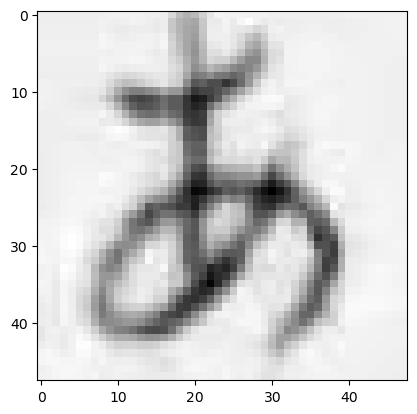

In [134]:
DATADIR = "../data/hiragana73"
CATEGORIES = ["U3042", "U3044", "U3046", "U3048", "U304A"]
category = CATEGORIES[0] # 0: あ, 1: い
path = os.path.join(DATADIR, category)

image_name = os.listdir(path)[9]
img_array = cv2.imread(os.path.join(path, image_name), cv2.IMREAD_GRAYSCALE)
print(img_array)
plt.imshow(img_array, cmap="gray")
plt.show()

In [135]:
test = make_input2(img_array)
test = test.astype(np.float32)
test = torch.from_numpy(test)

In [120]:
test.size()

torch.Size([1, 3, 48, 48])

In [121]:
test.dtype

torch.float32

In [136]:
points = gen2(test)
plotline = PlotLine2(48)
line = plotline(points)

<AxesSubplot: >

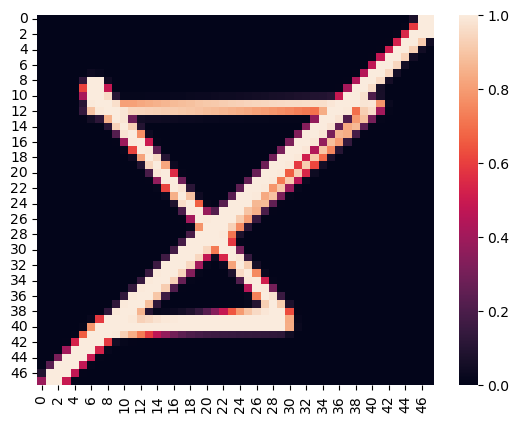

In [137]:
sns.heatmap(line.detach().numpy()[0])

In [143]:
points

tensor([[[1.8811e-04, 4.7000e+01, 2.5006e-01],
         [1.7083e-04, 4.7000e+01, 2.5004e-01],
         [5.1077e-01, 4.7000e+01, 2.5001e-01],
         [4.7000e+01, 1.1231e+00, 2.5001e-01],
         [3.9824e+01, 7.5688e+00, 2.5001e-01],
         [3.9686e+01, 2.9649e+01, 2.5002e-01],
         [8.5797e+00, 6.3760e+00, 2.5000e-01],
         [1.0234e+01, 6.5231e+00, 2.5000e-01],
         [3.8276e+01, 2.9339e+01, 2.5005e-01],
         [4.0426e+01, 8.2189e+00, 2.6343e-01],
         [6.1363e-01, 4.7000e+01, 2.5001e-01],
         [5.4207e-01, 4.7000e+01, 2.5001e-01],
         [4.7000e+01, 1.0987e+00, 2.5001e-01],
         [5.7977e-01, 4.7000e+01, 2.5001e-01],
         [5.9699e-01, 4.7000e+01, 2.5001e-01],
         [4.7000e+01, 1.0869e+00, 2.5001e-01],
         [8.1132e-01, 4.7000e+01, 2.5000e-01],
         [4.7000e+01, 1.3268e+00, 2.5001e-01],
         [1.1174e+01, 4.0661e+01, 2.5001e-01],
         [1.1693e+01, 5.4377e+00, 2.5001e-01]]], grad_fn=<AddBackward0>)

In [144]:
loss = disc2(points, test)

In [140]:
loss

tensor(2716059.2500, grad_fn=<SumBackward0>)

In [146]:
points[:,:,0:2]

tensor([[[1.8811e-04, 4.7000e+01],
         [1.7083e-04, 4.7000e+01],
         [5.1077e-01, 4.7000e+01],
         [4.7000e+01, 1.1231e+00],
         [3.9824e+01, 7.5688e+00],
         [3.9686e+01, 2.9649e+01],
         [8.5797e+00, 6.3760e+00],
         [1.0234e+01, 6.5231e+00],
         [3.8276e+01, 2.9339e+01],
         [4.0426e+01, 8.2189e+00],
         [6.1363e-01, 4.7000e+01],
         [5.4207e-01, 4.7000e+01],
         [4.7000e+01, 1.0987e+00],
         [5.7977e-01, 4.7000e+01],
         [5.9699e-01, 4.7000e+01],
         [4.7000e+01, 1.0869e+00],
         [8.1132e-01, 4.7000e+01],
         [4.7000e+01, 1.3268e+00],
         [1.1174e+01, 4.0661e+01],
         [1.1693e+01, 5.4377e+00]]], grad_fn=<SliceBackward0>)

In [147]:
torch.diff(points[:,:,0:2], dim=-2)

tensor([[[-1.7284e-05,  3.0518e-05],
         [ 5.1060e-01,  3.8147e-05],
         [ 4.6489e+01, -4.5877e+01],
         [-7.1758e+00,  6.4457e+00],
         [-1.3849e-01,  2.2080e+01],
         [-3.1106e+01, -2.3273e+01],
         [ 1.6545e+00,  1.4710e-01],
         [ 2.8042e+01,  2.2816e+01],
         [ 2.1502e+00, -2.1120e+01],
         [-3.9813e+01,  3.8781e+01],
         [-7.1554e-02,  3.8147e-06],
         [ 4.6458e+01, -4.5901e+01],
         [-4.6420e+01,  4.5901e+01],
         [ 1.7217e-02,  1.1444e-05],
         [ 4.6403e+01, -4.5913e+01],
         [-4.6189e+01,  4.5913e+01],
         [ 4.6189e+01, -4.5673e+01],
         [-3.5826e+01,  3.9334e+01],
         [ 5.1816e-01, -3.5223e+01]]], grad_fn=<SubBackward0>)

In [ ]:
distance = (torch.abs(torch.diff(points[:,:,0:2], dim=-2))).sum(dim=[-1, -2])

In [157]:
A_DIR = "../data/hiragana73/U3042"
#CATEGORIES = ["U3042", "U3044", "U3046", "U3048", "U304A"]

a_data = []

for img_path in os.listdir(A_DIR)[:100]:
    a_data.append(A_DIR + "/" + img_path)
        # print(DATADIR + "/" + CATEGORIES)
        # break

a_df = pd.DataFrame(a_data, columns=['path'])
#a_df.head()



,path
0,../data/hiragana73/U3042/1903_890549_0056.png
1,../data/hiragana73/U3042/1917_943914_0109.png
2,../data/hiragana73/U3042/1900_754949_0023.png
3,../data/hiragana73/U3042/1903_783111_0120.png
4,../data/hiragana73/U3042/1908_832572_0064.png


In [159]:
a_dataset = HiraganaDataset(a_df)

In [176]:
# バッチサイズの指定

batch_size = 1

# DataLoaderを作成

a_dataloader = DataLoader(a_dataset, batch_size=batch_size, shuffle=True)

# 動作確認
# イテレータに変換
a_batch_iterator = iter(a_dataloader)

# 1番目の要素を取り出す

inputs, labels = next(a_batch_iterator)

print(inputs.size())

print(labels.size())

torch.Size([1, 3, 48, 48])
torch.Size([1, 48, 48])


<AxesSubplot: >

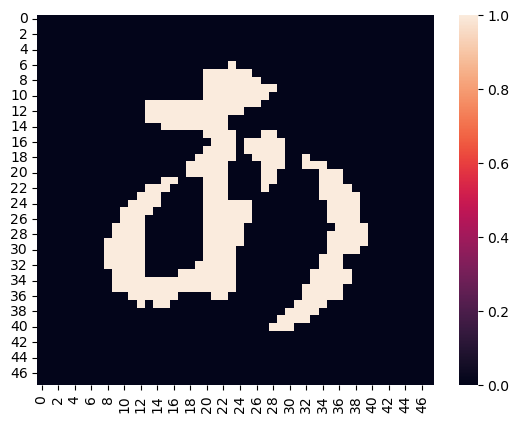

In [370]:
sns.heatmap(labels.detach().numpy()[0])

<AxesSubplot: >

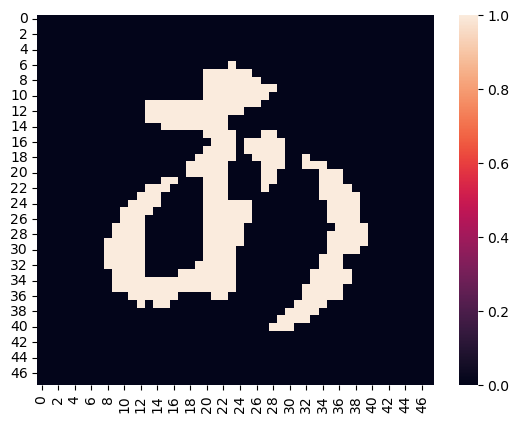

In [371]:
sns.heatmap(inputs.detach().numpy()[0, -1])

In [433]:
class Discriminator3(nn.Module):
    def __init__(self, img_size):
        super().__init__()
        self.img_size = img_size
        
        d = np.array(range(-img_size+1, img_size))
        x0 = (d**2 + (d**2).T).mean().astype(np.float32)
        self.x0 = float(x0)
        self.c0 = float(x0**(0.5))
        self.c1 = float(x0**(-0.5)/2.)
        self.c2 = float(-(x0**(-1.5)/8.))
        self.c3 = float(x0**(-2.5)/16.)

        self.plot_line = PlotLine2(self.img_size)
        self.criterion = nn.BCELoss()
        
        self.error_log = []
        self.distance_log = []
        self.distribution_log = []
        
    def forward(self, points, img):
        alpha = 1.0
        beta = 1.0
        gamma = 1.0
        
        eps = 1e-6

        # distance = (torch.sqrt((torch.diff(points[:,:,0:2], dim=-2)**2).sum(dim=-1) + eps)).sum()
        # distance = (torch.diff(points[:,:,0:2], dim=-2)**2).sum()
        # distance = (torch.abs(torch.diff(points[:,:,0:2], dim=-2))).sum(dim=[-1, -2])
        x = ((torch.diff(points, dim=-2))**2).sum(dim=-1)
        sqrt_x = self.c0 + self.c1*(x - self.x0) + self.c2*(x - self.x0)**2 + self.c3*(x - self.x0)**3
        # distance = sqrt_x.sum(dim=-1)
        distance = sqrt_x.sum(dim=-1)
        # print(distance.size())

        var = points[:,:,0:2].std(dim=-2).sum(dim=-1)
        
        line = self.plot_line(points)

        #error = ((self.c0*(line - img))**2).sum(dim=[-1,-2])
        error = self.criterion(line, img)*self.img_size**2
        #print(error.size())

        # distance_ = distance.unsqueeze(1)
        # # print(distance_.size())
        # error_ = error.unsqueeze(1)
        # # print(error_.size())
        # objects = torch.cat((distance_, error_), dim=1)
        # # print(objects.size())
        # losses = torch.max(objects, dim=1).values


        #losses = error
        #losses = alpha*error + beta*distance + 1./(gamma*var)
        losses = alpha*error + beta*distance
        # losses = (alpha*error + beta*distance)/(gamma*var)
        #loss = (error*distance)/var
        #loss = (alpha*((x - t)**2).sum() + beta*distance)/(var + eps)
        #loss = alpha*((x - t)**2).sum() + beta*(distance/(var + eps))
        #loss = (beta*((x - t)**2).sum())/(var + eps) + alpha*distance
        # self.p_map = x
        self.error_log.append(error.detach().numpy())
        self.distance_log.append(distance.detach().numpy())
        self.distribution_log.append(var.detach().numpy())
        loss = losses.sum()
        return loss

In [384]:
img_size = 48
n_point=20
a_gen = Generator2(img_size, n_point)
disc3 = Discriminator3(img_size)

243
210


In [330]:
def train1(gen, disc, inputs, labels, n_point=20, iteration = 1000, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'using: {device}')

    gen = gen.to(device)
    disc = disc.to(device)
    
    #optimizer=optim.Adam(gen2.parameters(), lr=lr)
    #optimizer=optim.AdamW(gen2.parameters(), lr=lr)
    #optimizer=optim.SGD(gen2.parameters(), lr=lr)
    #optimizer=optim.RMSprop(gen2.parameters(), lr=lr)
    #optimizer=optim.Adagrad(gen2.parameters(), lr=lr)
    optimizer=optim.Adadelta(gen.parameters(), lr=lr)
    
    # points_log = []
    # plot_log = []
    losses = []

    gen = gen.train()

    for i in range(iteration):
        optimizer.zero_grad()
        
        points = gen(inputs)
        
        loss = disc(points, labels)
        
        loss.backward()
    
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        if i%100 == 0:
            print(f'iter: {i}, loss: {loss}')
            # points_log.append(points)
            # plot_log.append(disc2.p_map.cpu())
    
    errors = disc.error_log
    distances = disc.distance_log
    distributions = disc.distribution_log
            
    # return points_log, plot_log, losses, errors, distances, distributions
    # return losses
    return losses, errors, distances, distributions

<AxesSubplot: >

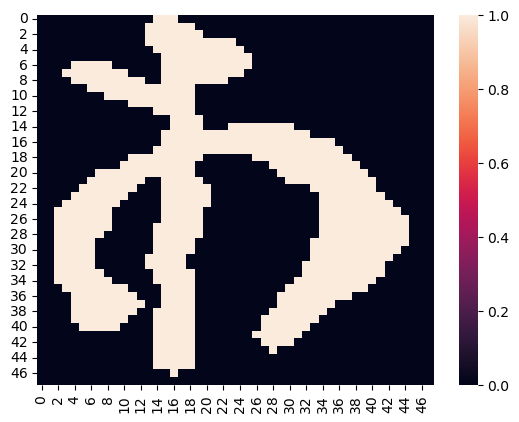

In [405]:
inputs, labels = next(a_batch_iterator)
sns.heatmap(labels.detach().numpy()[0])

In [406]:
a_gen = Generator2(img_size, n_point)
losses, errors, distances, distributions = train1(a_gen, disc3, inputs, labels, iteration=2000, lr=0.005)

243
210
using: cpu
iter: 0, loss: 28810.7578125
iter: 100, loss: 12160.875
iter: 200, loss: 2812.940185546875
iter: 300, loss: 2026.83203125
iter: 400, loss: 1297.9617919921875
iter: 500, loss: 1264.3138427734375
iter: 600, loss: 1249.9888916015625
iter: 700, loss: 1235.19873046875
iter: 800, loss: 1227.8653564453125
iter: 900, loss: 1217.335205078125
iter: 1000, loss: 1215.1712646484375
iter: 1100, loss: 1188.742431640625
iter: 1200, loss: 1186.5875244140625
iter: 1300, loss: 1185.0028076171875
iter: 1400, loss: 1183.185791015625
iter: 1500, loss: 1182.66845703125
iter: 1600, loss: 1177.83251953125
iter: 1700, loss: 1142.30078125
iter: 1800, loss: 1132.8765869140625
iter: 1900, loss: 1129.4661865234375


<AxesSubplot: >

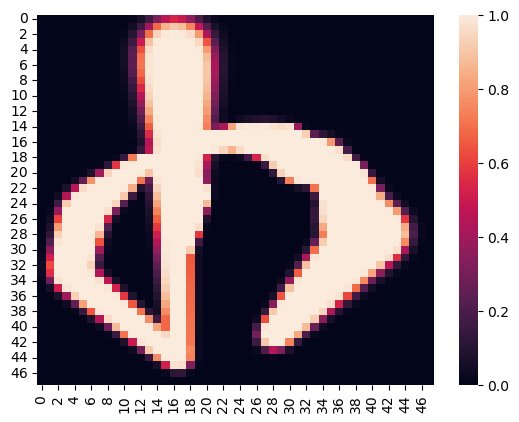

In [407]:
points = a_gen(inputs)
plotline = PlotLine2(48)
line = plotline(points)
sns.heatmap(line.detach().numpy()[0])

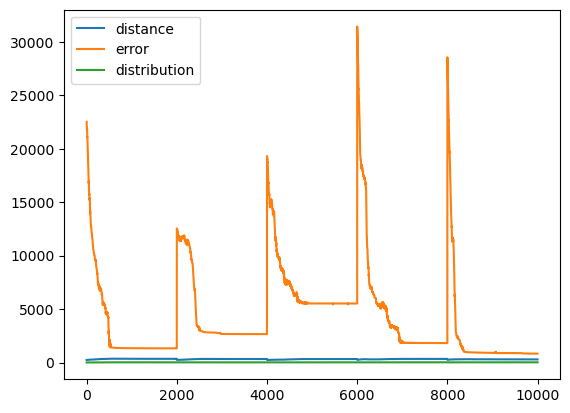

In [408]:
plt.plot(distances, label="distance")
plt.plot(errors, label="error")
plt.plot(distributions, label="distribution")
plt.legend()
plt.show()

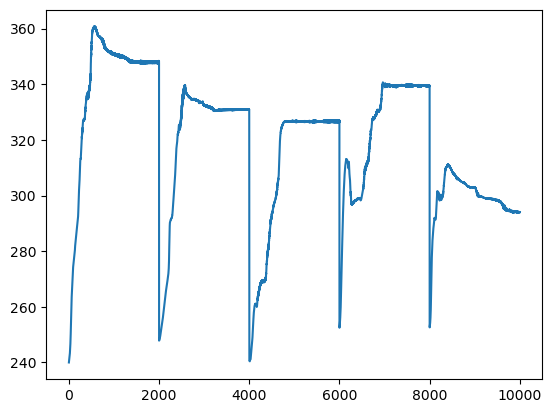

In [409]:
plt.plot(distances, label="distance")

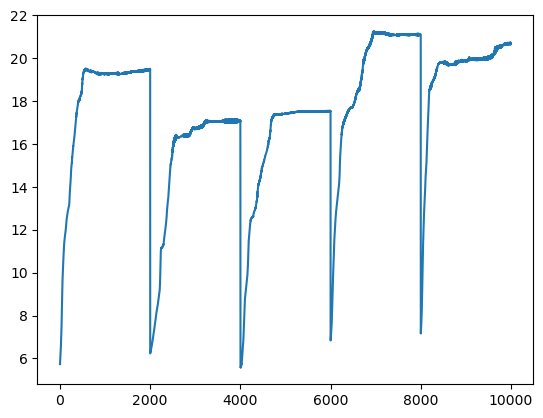

In [412]:
plt.plot(distributions, label="distribution")

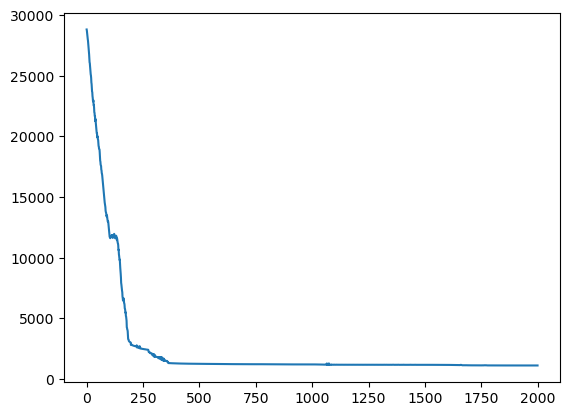

In [410]:
plt.plot(losses)

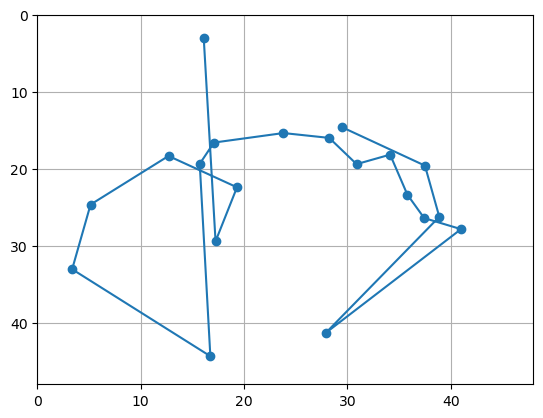

In [411]:
pos = points.detach().numpy()[0, :, 0:2]

fig, ax = plt.subplots(1,1)
ax.set_xlim(0, 48)
ax.set_ylim(0, 48)
ax.invert_yaxis()
ax.grid()
ax.plot(pos[:, 1], pos[:, 0], marker='o')
plt.show()

In [413]:
class Generator3(nn.Module):
    # 太さ対応生成器
    def __init__(self, img_size, n_point, w_m=0.25, w_M=4.):
        super().__init__()
        self.n_point = n_point
        self.img_size = img_size
        
        self.flatten = nn.Flatten()
        
        input_size = img_size**2
        output_size = 3*n_point
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, padding=0)
        self.pool = nn.MaxPool2d(2, stride=2)

        conved = (img_size - 4)//2
        conved = (conved - 4)//2
        hidden_size1 = 3*conved**2
        print(hidden_size1)
        
        hidden_size2 = 3*((conved**2 + output_size)//2)
        print(hidden_size2)

        self.fc1 = nn.Linear(hidden_size1, hidden_size2, bias=False)
        self.fc2 = nn.Linear(hidden_size2, output_size, bias=False)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.flatten = nn.Flatten()

        self.p_scale = float(img_size - 1)
        self.w_M = w_M
        self.w_m = w_m
        self.w_scale = w_M - w_m
        self.scale_W = torch.tensor([[[self.p_scale, self.p_scale, self.w_scale]]])
        self.scale_b = torch.tensor([[[0., 0., w_m]]])
        
    def forward(self, data):
        x = self.relu(self.conv1(data)) # conv1 -> relu
        x = self.pool(x) # pool
        x = self.relu(self.conv2(x)) # conv2 -> relu
        x = self.pool(x) # pool
        # x = x.view(x.size(0), -1) # reshape to use linear function
        x = self.flatten(x.permute(0,2,3,1))
        x = self.sigmoid(self.fc1(x)) # fc1 -> sigmoid
        y = self.sigmoid(self.fc2(x)) # fc1 -> sigmoid
        raw = y.reshape(-1, self.n_point, 3)
        out = raw*self.scale_W + self.scale_b
        return out

<AxesSubplot: >

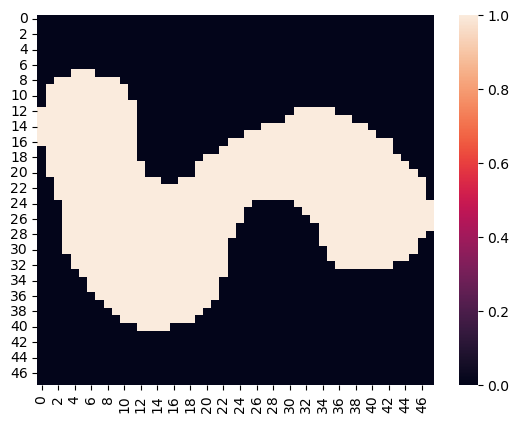

In [434]:
inputs, labels = next(batch_iterator)
inputs, labels = inputs[:1], labels[:1]
sns.heatmap(labels.detach().numpy()[0])

In [429]:
inputs[:1].size()

torch.Size([1, 3, 48, 48])

In [438]:
a_gen3 = Generator3(img_size, n_point, w_m=0.25, w_M=9.)
disc3 = Discriminator3(img_size)
losses, errors, distances, distributions = train1(a_gen3, disc3, inputs, labels, iteration=2000, lr=0.005)

243
210
using: cpu
iter: 0, loss: 16695.8828125
iter: 100, loss: 2928.714599609375
iter: 200, loss: 427.9481201171875
iter: 300, loss: 394.99560546875
iter: 400, loss: 385.0945739746094
iter: 500, loss: 376.0303649902344
iter: 600, loss: 370.9410095214844
iter: 700, loss: 368.30938720703125
iter: 800, loss: 362.5679931640625
iter: 900, loss: 357.614501953125
iter: 1000, loss: 351.41094970703125
iter: 1100, loss: 348.80462646484375
iter: 1200, loss: 345.0964050292969
iter: 1300, loss: 344.9530334472656
iter: 1400, loss: 343.6177673339844
iter: 1500, loss: 341.7618713378906
iter: 1600, loss: 338.6540832519531
iter: 1700, loss: 338.5133056640625
iter: 1800, loss: 337.3321533203125
iter: 1900, loss: 335.5080871582031


<AxesSubplot: >

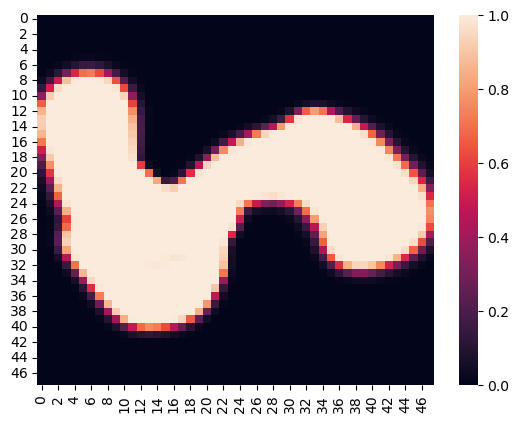

In [439]:
points = a_gen3(inputs)
plotline = PlotLine2(48)
line = plotline(points)
sns.heatmap(line.detach().numpy()[0])

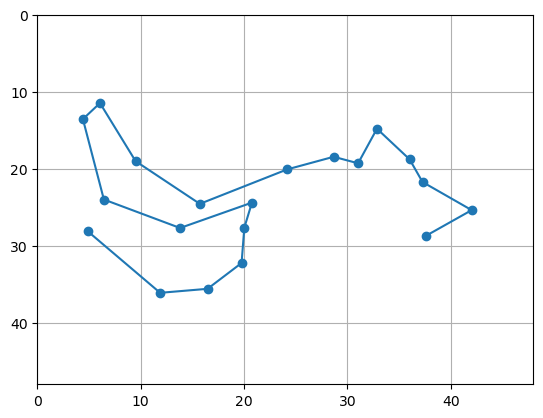

In [440]:
pos = points.detach().numpy()[0, :, 0:2]

fig, ax = plt.subplots(1,1)
ax.set_xlim(0, 48)
ax.set_ylim(0, 48)
ax.invert_yaxis()
ax.grid()
ax.plot(pos[:, 1], pos[:, 0], marker='o')
plt.show()

In [ ]:
# plotlineの入力値に最初にフィルターをかければ、点の数もいじれるのでは？

<AxesSubplot: >

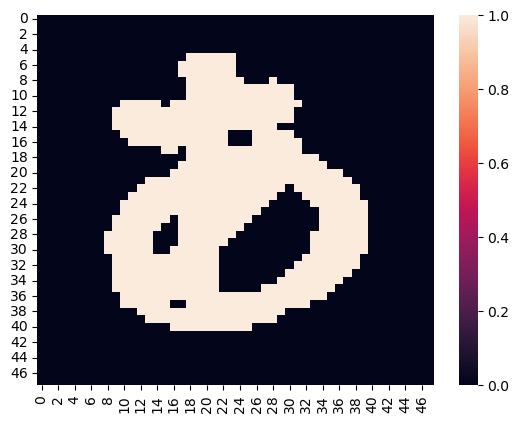

In [442]:
a_inputs, a_labels = next(a_batch_iterator)
sns.heatmap(a_labels.detach().numpy()[0])

<AxesSubplot: >

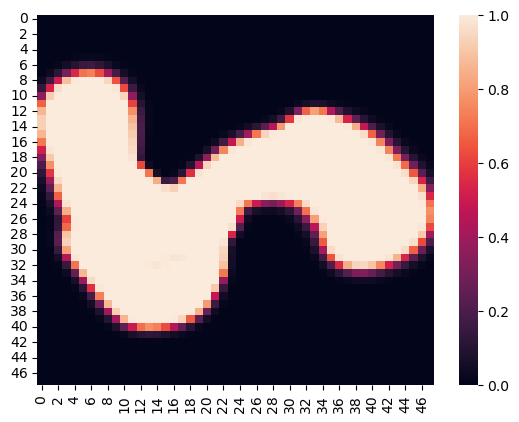

In [443]:
a_points = a_gen3(a_inputs)
plotline = PlotLine2(48)
a_line = plotline(a_points)
sns.heatmap(a_line.detach().numpy()[0])

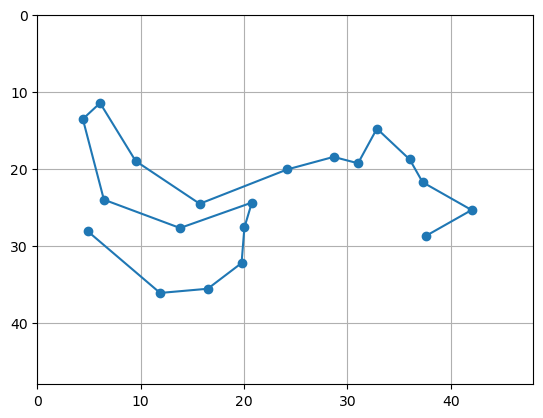

In [444]:
a_pos = a_points.detach().numpy()[0, :, 0:2]

fig, ax = plt.subplots(1,1)
ax.set_xlim(0, 48)
ax.set_ylim(0, 48)
ax.invert_yaxis()
ax.grid()
ax.plot(a_pos[:, 1], a_pos[:, 0], marker='o')
plt.show()

In [468]:
a_gen3 = Generator3(img_size, n_point, w_m=0.25, w_M=9.)
disc3 = Discriminator3(img_size)
losses, errors, distances, distributions = train1(a_gen3, disc3, a_inputs, a_labels, iteration=2000, lr=0.005)

243
210
using: cpu
iter: 0, loss: 11731.96875
iter: 100, loss: 8942.2451171875
iter: 200, loss: 3961.869384765625
iter: 300, loss: 2847.96875
iter: 400, loss: 2752.7314453125
iter: 500, loss: 2733.408935546875
iter: 600, loss: 2721.619140625
iter: 700, loss: 2716.2998046875
iter: 800, loss: 2713.28369140625
iter: 900, loss: 2711.680419921875
iter: 1000, loss: 2710.447509765625
iter: 1100, loss: 2709.609619140625
iter: 1200, loss: 2709.229248046875
iter: 1300, loss: 1294.4598388671875
iter: 1400, loss: 1163.9664306640625
iter: 1500, loss: 1149.2860107421875
iter: 1600, loss: 1146.1202392578125
iter: 1700, loss: 1137.141357421875
iter: 1800, loss: 1132.891357421875
iter: 1900, loss: 1130.819580078125


<AxesSubplot: >

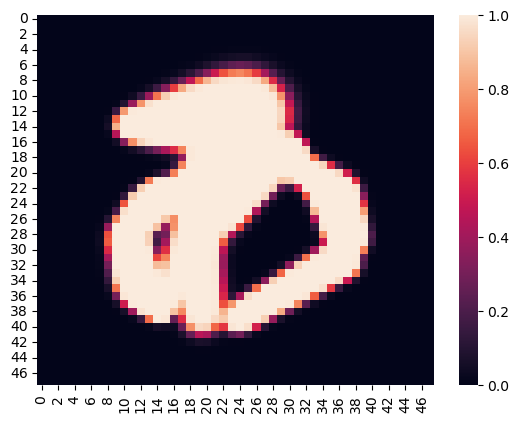

In [469]:
i_points = a_gen3(inputs)
plotline = PlotLine2(48)
i_line = plotline(i_points)
sns.heatmap(i_line.detach().numpy()[0])

<AxesSubplot: >

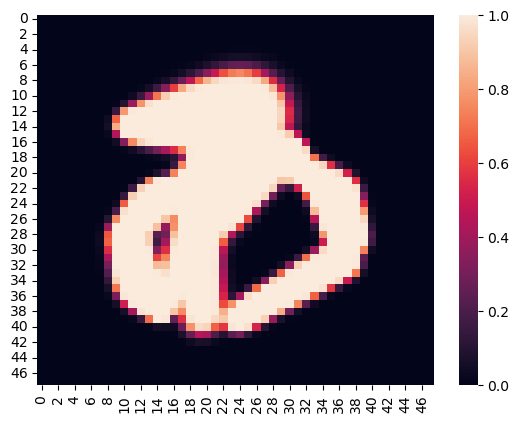

In [470]:
a_points = a_gen3(a_inputs)
plotline = PlotLine2(48)
a_line = plotline(a_points)
sns.heatmap(a_line.detach().numpy()[0])

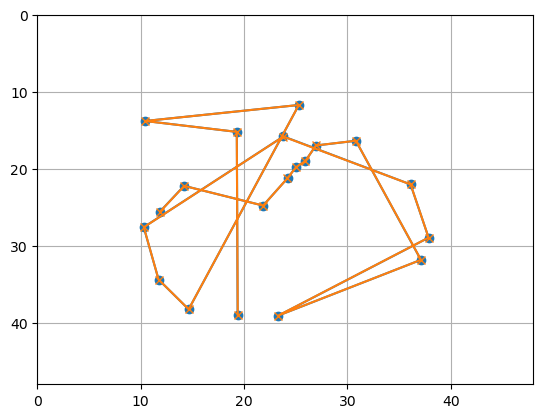

In [471]:
a_pos = a_points.detach().numpy()[0, :, 0:2]
i_pos = i_points.detach().numpy()[0, :, 0:2]

fig, ax = plt.subplots(1,1)
ax.set_xlim(0, 48)
ax.set_ylim(0, 48)
ax.invert_yaxis()
ax.grid()
ax.plot(a_pos[:, 1], a_pos[:, 0], marker='o')
ax.plot(i_pos[:, 1], i_pos[:, 0], marker='x')
plt.show()

In [478]:
random_input = torch.randn_like(inputs)

In [473]:
random_input.size()

torch.Size([1, 3, 48, 48])

<AxesSubplot: >

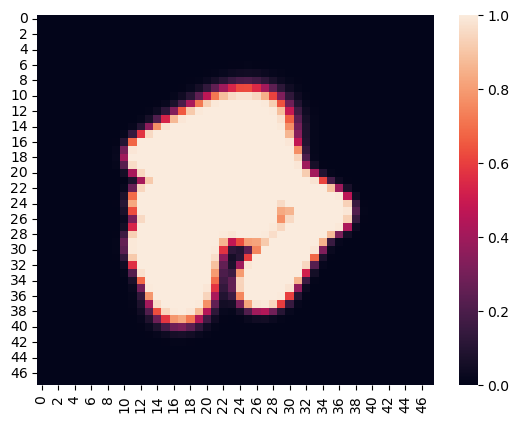

In [479]:
test_line = plotline(a_gen3(random_input))
sns.heatmap(test_line.detach().numpy()[0])

In [482]:
class Generator4(nn.Module): # 中でソートしてみた。性能が下がるだけか？
    # 太さ対応生成器
    def __init__(self, img_size, n_point, w_m=0.25, w_M=4.):
        super().__init__()
        self.n_point = n_point
        self.img_size = img_size
        
        self.flatten = nn.Flatten()
        
        input_size = img_size**2
        output_size = 3*n_point
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, padding=0)
        self.pool = nn.MaxPool2d(2, stride=2)

        conved = (img_size - 4)//2
        conved = (conved - 4)//2

        self.conved = conved

        hidden_size1 = 3*conved**2
        #print(hidden_size1)
        
        hidden_size2 = 3*((conved**2 + output_size)//2)
        #print(hidden_size2)

        self.fc1 = nn.Linear(hidden_size1, hidden_size2, bias=False)
        self.fc2 = nn.Linear(hidden_size2, output_size, bias=False)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.flatten = nn.Flatten()

        self.p_scale = float(img_size - 1)
        self.w_M = w_M
        self.w_m = w_m
        self.w_scale = w_M - w_m
        self.scale_W = torch.tensor([[[self.p_scale, self.p_scale, self.w_scale]]])
        self.scale_b = torch.tensor([[[0., 0., w_m]]])
        
    def forward(self, data):
        N = data.size()[0]

        x = self.relu(self.conv1(data)) # conv1 -> relu
        x = self.pool(x) # pool
        x = self.relu(self.conv2(x)) # conv2 -> relu
        x = self.pool(x) # pool
        # x = x.view(x.size(0), -1) # reshape to use linear function

        xf = x.reshape(N, 3, self.conved**2)
        val = xf[:, 0]
        idx = torch.argsort(val, dim = -1)
        sorted1 = torch.gather(xf, -1, idx.unsqueeze(1).repeat(1,3,1))
        x1 = self.flatten(sorted1.permute(0, 2, 1))

        # x = self.flatten(x.permute(0,2,3,1))
        x1 = self.sigmoid(self.fc1(x1)) # fc1 -> sigmoid

        y = self.sigmoid(self.fc2(x1)) # fc1 -> sigmoid
        raw = y.reshape(-1, self.n_point, 3)
        out = raw*self.scale_W + self.scale_b
        return out

In [487]:
gen4 = Generator4(img_size, n_point, w_m=0.25, w_M=9.)
disc3 = Discriminator3(img_size)
losses, errors, distances, distributions = train1(gen4, disc3, inputs, labels, iteration=100, lr=0.005)

using: cpu
iter: 0, loss: 19730.0703125


<AxesSubplot: >

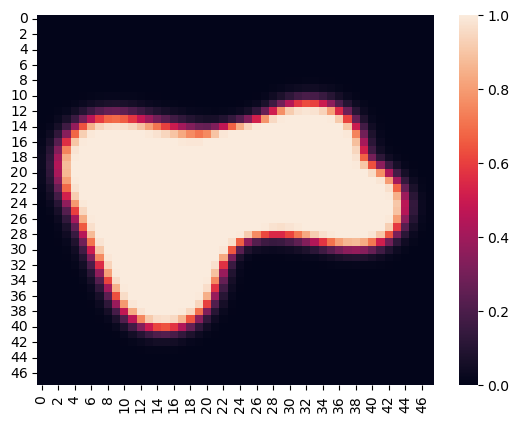

In [488]:
points4 = gen4(inputs)
line4 = plotline(points4)
sns.heatmap(line4.detach().numpy()[0])

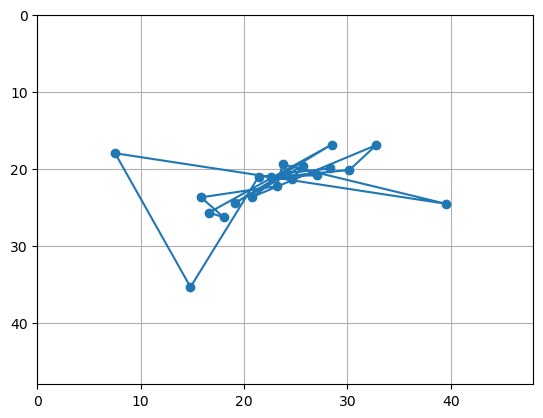

In [489]:
pos4 = points4.detach().numpy()[0, :, 0:2]

fig, ax = plt.subplots(1,1)
ax.set_xlim(0, 48)
ax.set_ylim(0, 48)
ax.invert_yaxis()
ax.grid()
ax.plot(pos4[:, 1], pos4[:, 0], marker='o')
plt.show()

<AxesSubplot: >

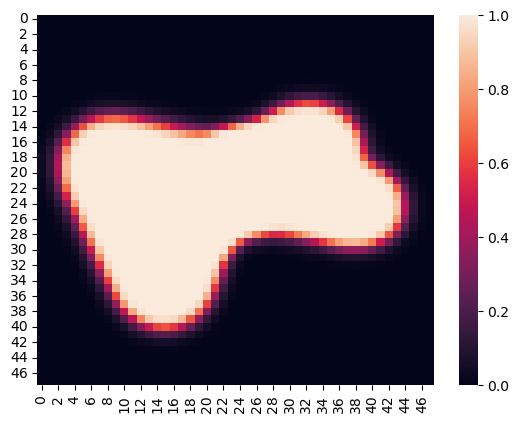

In [490]:
a_points4 = gen4(a_inputs)
a_line4 = plotline(a_points4)
sns.heatmap(a_line4.detach().numpy()[0])

In [ ]:
class Generator5(nn.Module): # 中でソートしてみた。性能が下がるだけか？ part2
    # 太さ対応生成器
    def __init__(self, img_size, n_point, w_m=0.25, w_M=4.):
        super().__init__()
        self.n_point = n_point
        self.img_size = img_size
        
        self.flatten = nn.Flatten()
        
        input_size = img_size**2
        output_size = 3*n_point
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5, padding=0) # 0チャンネル目で残りをソートする
        self.pool = nn.MaxPool2d(2, stride=2)

        conved = (img_size - 4)//2
        conved = (conved - 4)//2

        self.conved = conved

        hidden_size1 = 3*conved**2
        #print(hidden_size1)
        
        hidden_size2 = 3*((conved**2 + output_size)//2)
        #print(hidden_size2)

        self.fc1 = nn.Linear(hidden_size1, hidden_size2, bias=False)
        self.fc2 = nn.Linear(hidden_size2, output_size, bias=False)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.flatten = nn.Flatten()

        self.p_scale = float(img_size - 1)
        self.w_M = w_M
        self.w_m = w_m
        self.w_scale = w_M - w_m
        self.scale_W = torch.tensor([[[self.p_scale, self.p_scale, self.w_scale]]])
        self.scale_b = torch.tensor([[[0., 0., w_m]]])
        
    def forward(self, data):
        N = data.size()[0]

        x = self.relu(self.conv1(data)) # conv1 -> relu
        x = self.pool(x) # pool
        x = self.relu(self.conv2(x)) # conv2 -> relu
        x = self.pool(x) # pool
        # x = x.view(x.size(0), -1) # reshape to use linear function

        xf = x.reshape(N, 4, self.conved**2)
        val = xf[:, 0]
        obj = xf[:, 1:]
        idx = torch.argsort(val, dim = -1)
        sorted1 = torch.gather(obj, -1, idx.unsqueeze(1).repeat(1,3,1))
        x1 = self.flatten(sorted1.permute(0, 2, 1))

        # x = self.flatten(x.permute(0,2,3,1))
        x1 = self.sigmoid(self.fc1(x1)) # fc1 -> sigmoid

        y = self.sigmoid(self.fc2(x1)) # fc1 -> sigmoid
        raw = y.reshape(-1, self.n_point, 3)
        out = raw*self.scale_W + self.scale_b
        return out